In [83]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater
from causalbenchmark.novo import misc

In [44]:
spark_generator = NewsHeadlines(locs=['gb', 'de', 'fr', 'it', 'nl']).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/5 [00:00<?, ?it/s]

550074

In [45]:
setting_generation_prompt_template = \
'''We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment and outcome variable) and no causal parents
- mediator variables may or may not be observable, and should always have at least one causal parents (for example, a treatment variable) and at least one causal child (for example, the outcome variable)
- collider variables may or may not be observable, and should always have at least two causal parents (for example, a treatment and outcome variable) and no causal children

Answer concisely and precisely in the desired format. Carefully complete each of these tasks in order.

1. Write a short description of what the article is about and what causal model make inform the reasoning behind an argument the might make.
2. Propose 1 outcome variable that the news article is either implicitly or explicitly addressing that people are most likely to be interested in studying, especially if people tend to have misconceptions about it
3. Propose 2 treatment variables that either directly or indirectly affect the selected outcome variable and are the most interesting to study
4. Propose 3 confounder variables that affect some reasonable combination of the outcome and treatment variables
5. Propose 3 mediator variables that affect and are affected by some reasonable combination of any other variables
6. Propose 2 collider variables that are affected by some reasonable combination of any other variables

Here is the beginning of the new article:
```
{spark}
```

The variables and causal graph should, where possible, use specific details such as names and locations mentioned in the article. Also, generally the variable value "0" should correspond to the negative or control while the value "1" should correspond to the positive or greater value.

Take a deep breath and think step-by-step about how you will do this.'''
graph_selection_prompt_template = \
'''1. From all proposed confounder, mediator, and collider variables, select between 3-5 variables that are most interesting to study and together with the treatment and outcome variables result in a realistic interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than 3 parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list called `nodes` of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to the index)
- `parents`: a python list of the names of the parents of the variable (make sure they match the corresponding `name` field of the parent nodes)

Take a deep breath and think step-by-step about how you will do this.'''
stats_prompt_template = \
'''We have a causal bayes net based on the following article:

```
{spark}
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

{questions}

Where the variables are defined as:
{descriptions}

For each question above, answer with the lower and upper bound estimates of the probabilities as a python dictionary where the key corresponds to the question index in exactly the following format:

```python
probabilities = {{
  1: [0.3, 0.4],
  ...
}}
```

Answer concisely and precisely in the desired format.'''

In [51]:
ctx = Story(story_root=misc.data_root() / 'stories', story_id='test2')
# ctx = Story(story_root=misc.data_root() / 'stories')
# ctx.populate_defaults()
ctx.include(
    FixedTemplate('setting', setting_generation_prompt_template),
    FixedTemplate('graph', graph_selection_prompt_template),
    StatisticsPrompting(stats_prompt_template),
    spark_generator,
);
# print(ctx)
print(ctx['seed'])
print(ctx['spark'])

1423874
Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English


In [97]:
print(ctx['setting'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment

In [98]:
print(ctx['graph'])

1. From all proposed confounder, mediator, and collider variables, select between 3-5 variables that are most interesting to study and together with the treatment and outcome variables result in a realistic interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than 3 parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list called `nodes` of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to t

In [99]:
#################################################

nodes = [
    {"name": "EG", "description": "Economic Growth", "type": "outcome", "observed": True, "values": ["No Growth", "Positive Growth"], "parents": ["GEP", "IP", "UR", "CC"]},
    {"name": "IP", "description": "Industrial Production", "type": "treatment", "observed": True, "values": ["Decrease", "Increase"], "parents": ["GEP"]},
    {"name": "UR", "description": "Unemployment Rate", "type": "treatment", "observed": True, "values": ["Increase", "Decrease"], "parents": ["GEP"]},
    {"name": "GEP", "description": "Government Economic Policies", "type": "confounder", "observed": True, "values": ["Restrictive", "Stimulative"], "parents": []},
    {"name": "CC", "description": "Consumer Confidence", "type": "mediator", "observed": True, "values": ["Low", "High"], "parents": ["IP", "UR"]},
    {"name": "MP", "description": "Market Performance", "type": "collider", "observed": True, "values": ["Poor", "Good"], "parents": ["IP", "EG"]}
]



#################################################
varvals = {node['name']: node['values'] for node in nodes}
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))

ctx['nodes'] = nodes


/tmp/ipykernel_4010087/2912959094.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


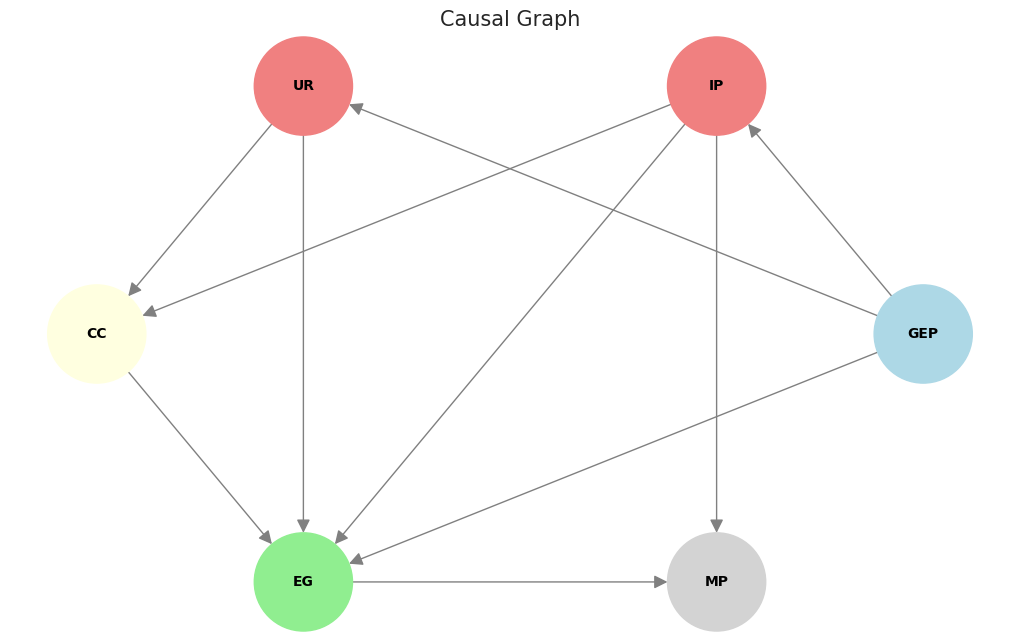

In [18]:
G = nx.DiGraph()

# Add nodes and edges to the graph
for node in ctx['nodes']:
    G.add_node(node['name'], type=node['type'], observed=node['observed'])

    for parent in node['parents']:
        G.add_edge(parent, node['name'])

# Define node colors based on type
node_colors = {'treatment': 'lightcoral', 'outcome': 'lightgreen', 'confounder': 'lightblue', 'mediator': 'lightyellow', 'collider': 'lightgray'}
colors = [node_colors[G.nodes[n]['type']] for n in G.nodes]

# Draw the graph
plt.figure(figsize=(10, 6))
# pos = nx.spring_layout(G)
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=5000, font_size=10, font_weight='bold', edge_color='gray', arrowsize=20)
plt.title('Causal Graph', size=15);
plt.tight_layout();

In [101]:
print(ctx['stats'])

We have a causal bayes net based on the following article:

```
Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "GEP" is "Stimulative" (rather than "Restrictive")?
2. when "GEP" is "Restrictive": what is the probability that "IP" is "Increase" (rather than "Decrease")?
3. when "GEP" is "Stimulative": what is the probability that "IP" is "Increase" (rather than "Decrease")?
4. when "GEP" is "Restrictive": what is the probability that "UR" is "Decrease" (rather than "Increase")?
5. when "GEP" is "Stimulative": what is the probability t

In [23]:
#################################################

probabilities = {
    1: [0.7, 0.8], # High probability of stimulative policies given economic growth
    2: [0.1, 0.2], # Low probability of industrial production increasing under restrictive policies
    3: [0.7, 0.8], # High probability of industrial production increasing under stimulative policies
    4: [0.2, 0.3], # Low probability of unemployment decreasing under restrictive policies
    5: [0.7, 0.8], # High probability of unemployment decreasing under stimulative policies
    6: [0.1, 0.2], # Low probability of high consumer confidence with decreasing IP and increasing UR
    7: [0.4, 0.5], # Moderate probability of high consumer confidence with decreasing IP and decreasing UR
    8: [0.2, 0.3], # Low probability of high consumer confidence with increasing IP and increasing UR
    9: [0.6, 0.7], # High probability of high consumer confidence with increasing IP and decreasing UR
    10: [0.1, 0.2], # Very low probability of positive economic growth in this scenario
    11: [0.2, 0.3], # Slightly higher probability of positive economic growth with high CC
    12: [0.3, 0.4], # Moderate probability of positive economic growth with decreasing UR
    13: [0.4, 0.5], # Higher probability of positive economic growth with high CC and decreasing UR
    14: [0.3, 0.4], # Moderate probability of positive economic growth with increasing IP
    15: [0.5, 0.6], # Higher probability of positive economic growth with high CC and increasing IP
    16: [0.4, 0.5], # Moderate probability of positive economic growth with decreasing UR
    17: [0.6, 0.7], # Higher probability of positive economic growth with high CC and decreasing UR
    18: [0.2, 0.3], # Low probability of positive economic growth with decreasing IP and increasing UR
    19: [0.3, 0.4], # Slightly higher probability of positive growth with high CC
    20: [0.4, 0.5], # Moderate probability of positive growth with decreasing UR
    21: [0.5, 0.6], # Higher probability of positive growth with high CC and decreasing UR
    22: [0.6, 0.7], # High probability of positive economic growth with increasing IP
    23: [0.8, 0.9], # Very high probability of positive growth with high CC and increasing IP
    24: [0.7, 0.8], # High probability of positive growth with increasing IP and decreasing UR
    25: [0.9, 1.0], # Very high probability of positive growth with high CC, increasing IP, and decreasing UR
    26: [0.3, 0.4], # Moderate probability of good market performance with decreasing IP and no growth
    27: [0.5, 0.6], # Higher probability of good market performance with decreasing IP but positive growth
    28: [0.4, 0.5], # Moderate probability of good market performance with increasing IP and no growth
    29: [0.7, 0.8], # High probability of good market performance with increasing IP and positive growth
}



#################################################
probs = probabilities
ctx['probs'] = probs

In [24]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items())]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['probs'])
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in ctx['nodes']:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)
# net

In [25]:
def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome):
    def ate_fn():
        return net.ate(treatment)[outcome].item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn

In [64]:
treatment1, treatment2 = [node['name'] for node in ctx['nodes'] if node['type'] == 'treatment']
t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]

print(tabulate([
    [treatment1, *t1vals],
    [treatment2, *t2vals],
    [outcome, *ovals]
]))

ate1, ate2, corr1, corr2 = mc_samples(100, make_ate_fn(treatment1, outcome), make_ate_fn(treatment2, outcome),
                                      make_corr_fn(treatment1, outcome), make_corr_fn(treatment2, outcome)).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{t1vals[1]}', f'{treatment1}', f'{ovals[1]}', f'{outcome}', ate1.mean(), corr1.mean(), ],
    [f'{t2vals[1]}', f'{treatment2}', f'{ovals[1]}', f'{outcome}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

--  ---------  ---------------
IP  Decrease   Increase
UR  Increase   Decrease
EG  No Growth  Positive Growth
--  ---------  ---------------


  0%|          | 0/100 [00:00<?, ?it/s]

'GEP' means Government Economic Policies
'IP' means Industrial Production
'UR' means Unemployment Rate
'CC' means Consumer Confidence
'EG' means Economic Growth
'MP' means Market Performance
Treatment Value    Treatment    Outcome Value    Outcome         ATE    Correlation
-----------------  -----------  ---------------  ---------  --------  -------------
Increase           IP           Positive Growth  EG         0.354034       0.145059
Decrease           UR           Positive Growth  EG         0.197525      -0.113168


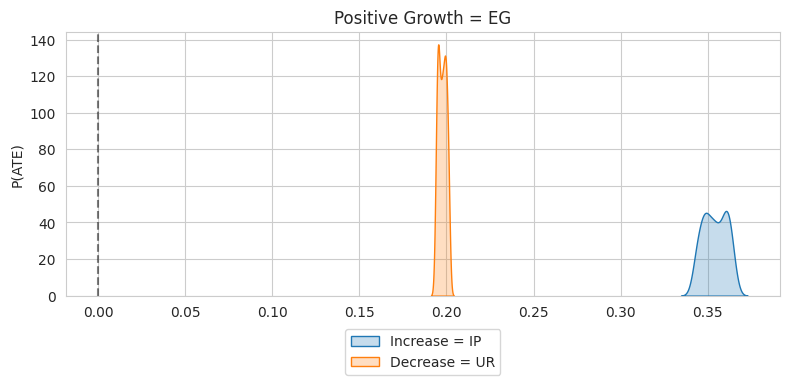

In [65]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{t1vals[1]} = {treatment1}', fill=True);
sns.kdeplot(ate2, label=f'{t2vals[1]} = {treatment2}', fill=True);
plt.title(f'{ovals[1]} = {outcome}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

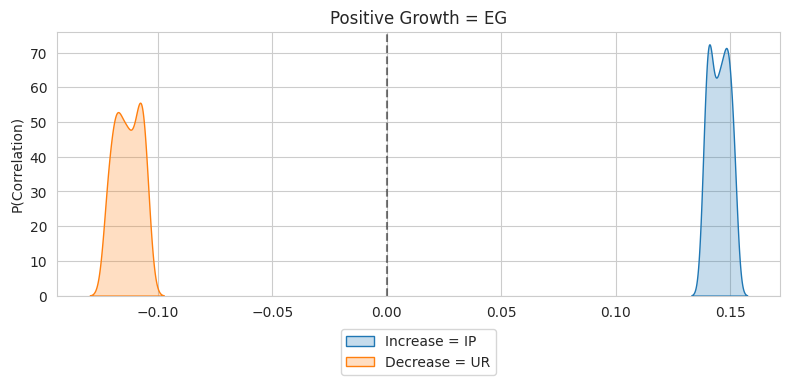

In [66]:
plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{t1vals[1]} = {treatment1}', fill=True);
sns.kdeplot(corr2, label=f'{t2vals[1]} = {treatment2}', fill=True);
plt.title(f'{ovals[1]} = {outcome}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

In [67]:
i = len(list(ctx._root.glob("*.json")))+1
path = ctx._root / f'test{i}'
while path.exists():
    i += 1
    path = ctx._root / f'test{i}'
ctx.save(path.stem)

PosixPath('/home/fleeb/workspace/code/cladder/novo-data/stories/test5.json')

In [68]:
print(ctx['descriptions'])

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"


In [63]:
outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    net.ate(node1['name'])[node2['name']].item(), 
                    net.correlation(node1['name'], node2['name']).item(),
                    f'{node1["values"][1]} {node1["name"]}', 
                    f'{node2["values"][1]} {node2["name"]}', 
                    node1['description'], 
                    node2['description'], 
                    ])
print(tabulate(tbl, headers=['ATE', 'Correlation', 'Treatment', 'Outcome', 'Treatment Description', 'Outcome Description']))

         ATE    Correlation  Treatment           Outcome             Treatment Description         Outcome Description
------------  -------------  ------------------  ------------------  ----------------------------  ----------------------------
 0.6            -0.130868    Stimulative GEP     Increase IP         Government Economic Policies  Industrial Production
 0.5             0.0519683   Stimulative GEP     Decrease UR         Government Economic Policies  Unemployment Rate
 0.265794       -0.0779333   Stimulative GEP     High CC             Government Economic Policies  Consumer Confidence
 0.484723       -0.187706    Stimulative GEP     Positive Growth EG  Government Economic Policies  Economic Growth
 0.212796        0.0678635   Stimulative GEP     Good MP             Government Economic Policies  Market Performance
 0              -0.130868    Increase IP         Stimulative GEP     Industrial Production         Government Economic Policies
 0              -0.00680091  Increa

In [114]:
prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence. For each set of questions, fill in the blank and then for each possible descriptor of the probability, provide a reasonable quantitative estimate for the lower and upper bounds of the probability that would be implied by that evidence if the variable took on the value corresponding to 1. Note that your estimates for each descriptor should conform to common sense and reflect the meaning of the variable taking on the value corresponding to 1.

For example, if the question is:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: ['low', 'high', 'very high']

1. "Tax Rate" can either be 0="Decreased" or 1="Increased".
2. "Vaccination Status" can either be 0="Not Vaccinated" or 1="Vaccinated".
...

You should answer in the following format:

```python
evidence = {{
  1: {{'blank': {{'Decreased': 'decreased taxes', 'Increased': 'increased taxes'}} 'implications': {{'low': [0.2, 0.4], 'high': [0.6, 0.8], 'very high': [0.8, 0.9]}}}},
  2: {{'blank': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}} 'implications': {{'low': [0.3, 0.5], 'high': [0.7, 0.9], 'very high': [0.85, 0.99]}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

q_template = '{i}. "{variable}" can either be 0="{value}" or 1="{othervalue}".'

verbs = [
    'very low', 'low', 'moderate', 'high', 'very high',
    # 'extremely small', 'small', 'large', 'extremely large',
    'significant', 'negligible', 'substantial', 'insignificant', 'considerable',
    # 'improbable', 'likely', 'probable', 'unlikely', 'certain',
]

In [115]:
nodes = ctx['nodes']
qlines = []
i = 1
for node in nodes:
    v0, v1 = node['values']
    qlines.append(q_template.format(i=i, variable=node['name'], value=v1, othervalue=v0))
    i += 1
questions = '\n'.join(qlines)

In [116]:
tmpl = SimpleTemplater(prompt_template)
tmpl.keys

{'descriptions', 'descriptor', 'descriptors', 'questions', 'spark'}

In [117]:
# print(tmpl.fill_in(dict(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions)))
print(prompt_template.format(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions))

We have a causal bayes net based on the following article:

```
Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English
```

And, for additional context, here are the variables and their descriptions:

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"

Now we would like to verbalize the description of some evidence. For each set of questions, fill in the blank and then for each possible descriptor of the probability, provide a reasonable quantitative estimate for the lower and upper bounds of the probability that would be implied by that evidence if the variable to

In [ ]:
line_template = 'The probability that __ is {quantity}'

In [120]:
evidence = {
  1: {
    'blank': {'Stimulative': 'stimulative government economic policies', 'Restrictive': 'restrictive government economic policies'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  2: {
    'blank': {'Increase': 'an increase in industrial production', 'Decrease': 'a decrease in industrial production'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  3: {
    'blank': {'Decrease': 'a decrease in the unemployment rate', 'Increase': 'an increase in the unemployment rate'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  4: {
    'blank': {'High': 'high consumer confidence', 'Low': 'low consumer confidence'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  5: {
    'blank': {'Positive Growth': 'positive economic growth', 'No Growth': 'no economic growth'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  6: {
    'blank': {'Good': 'good market performance', 'Poor': 'poor market performance'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  }
}

all(e1['implications'] == e2['implications'] for e1, e2 in combinations(evidence.values(), 2))


True

In [121]:
print(ctx['spark'])

Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English


In [ ]:
setting = {
    "introduction": "In light of China's notable economic growth of 4.9% amidst the global coronavirus pandemic, as reported by the Daily Mail, this causal model seeks to unravel the underlying factors contributing to this growth. It aims to provide insights into how different aspects such as industrial production and unemployment rates have played a role in shaping China's economic trajectory during this period.",
    "overview": "Our causal graph is a simplified representation of the complex interplay between various economic factors. It includes variables like government policies, industrial production, and unemployment rates, each affecting the other in unique ways. For instance, government policies can be a confounder, affecting both unemployment and industrial production, while consumer confidence acts as a mediator, reflecting the impact of industrial changes on the overall economic growth.",
    "questions": {
        1: {"question": "Does an increase in industrial production have a positive effect on China's economic growth?", "answer": "yes", "explanation": "Given the economic context, an increase in industrial production likely contributes positively to economic growth.", "inequality": "ATE(IP) > 0"},
        2: {"question": "Is the positive impact of decreasing unemployment on economic growth greater than that of increasing industrial production?", "answer": "no", "explanation": "Industrial production typically has a more direct and significant impact on economic growth compared to changes in unemployment rates.", "inequality": "ATE(UR) > ATE(IP)"},
        3: {"question": "Does a decrease in the unemployment rate positively influence China's economic growth?", "answer": "yes", "explanation": "Lower unemployment generally leads to higher consumer spending and economic growth.", "inequality": "ATE(UR) > 0"},
        4: {"question": "Is the impact of industrial production on economic growth stronger than the influence of government economic policies?", "answer": "yes", "explanation": "While government policies set the stage, industrial production is a more direct driver of economic growth.", "inequality": "ATE(IP) > ATE(GEP)"},
        5: {"question": "Does a stimulative government policy have a greater positive effect on economic growth than an increase in industrial production?", "answer": "no", "explanation": "Industrial production, being a direct economic activity, likely has a stronger immediate impact on economic growth than general government policies.", "inequality": "ATE(GEP) > ATE(IP)"}
    },
}


In [227]:
import pandas as pd
from dowhy import CausalModel
from networkx.drawing.nx_pydot import write_dot

In [226]:
G = nx.DiGraph()
for var in net.vars:
    G.add_node(var.name)
    for parent in var.parents:
        G.add_edge(parent.name, var.name)
G

In [127]:
def convert_to_dot(nodes):
    # Start the DOT graph definition
    dot_graph = "digraph {\n"

    # Iterate over nodes to add them to the graph
    for node in nodes:
        dot_graph += f'    "{node["name"]}" [label="{node["name"]}: {node["description"]}"];\n'

        # Add edges from parents to this node
        for parent in node.get("parents", []):
            dot_graph += f'    "{parent}" -> "{node["name"]}";\n'

    dot_graph += "}\n"
    return dot_graph

In [129]:
print(ctx['descriptions'])

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"


In [221]:
# Create a dummy DataFrame
# The columns should match the nodes in your causal graph
dummy_data = pd.DataFrame({
    'EG': [0],   # Economic Growth
    'IP': [0],   # Industrial Production
    'UR': [0],   # Unemployment Rate
    'GEP': [0],  # Government Economic Policies
    'CC': [0],   # Consumer Confidence
    'MP': [0]    # Market Performance
})

# Define your DOT graph (use the function from the previous response)
dot_graph = convert_to_dot(nodes)

# Instantiate the CausalModel with dummy data
model = CausalModel(
    data=dummy_data,
    treatment='CC',  # Replace with your treatment variable name
    outcome='EG',      # Replace with your outcome variable name
    graph=dot_graph
)

identified_estimand = model.identify_effect()
print(identified_estimand)

from sympy import pretty

# # Assuming 'identified_estimand' is the object returned by model.identify_effect()
# 
# # Print the basic information about the estimand
# print("Estimand Identifier:", identified_estimand.identifier)
# print("Estimand Type:", identified_estimand.estimand_type)
# 
# # Accessing the estimands attribute
# estimands_info = identified_estimand.estimands
# 
# # Displaying the estimands information
# print("Estimands Information:")
# print(estimands_info)

identified_estimand.backdoor_variables, identified_estimand.default_backdoor_id

ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[EG|UR,IP])
d[CC]             
Estimand assumption 1, Unconfoundedness: If U→{CC} and U→EG then P(EG|CC,UR,IP,U) = P(EG|CC,UR,IP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


({'backdoor1': ['UR', 'IP', 'GEP'],
  'backdoor2': ['UR', 'IP'],
  'backdoor': ['UR', 'IP']},
 'backdoor2')

In [222]:
sym = identified_estimand.estimands[identified_estimand.default_backdoor_id]['estimand']
sym

  d               
─────(E[EG|UR,IP])
d[CC]             

In [223]:
print(pretty(sym))

  d               
─────(E[EG|UR,IP])
d[CC]             


In [224]:
do = sym.args[1][0].args[0][0].name
exp = sym.args[0].args[0].name
if '|' in exp:
    outcome, cond = exp.split('|')
    cond = cond.split(',')
else:
    outcome = exp
    cond = []
    
print(outcome, do, cond)

EG CC ['UR', 'IP']


In [229]:
dummyvars = 'uvwxyz'
assert len(cond) <= len(dummyvars)
psum = ''
condsuffix = ''
if len(cond):
    psum = ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))
    psum = f'E_{{{psum}}} '

    condsuffix = ',' + ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))

expr = f'{psum}{"[ " if len(cond) else ""}p({outcome}=1 | {do}=1{condsuffix}) - p({outcome}=1 | {do}=0{condsuffix}){" ]" if len(cond) else ""}'

# expr = (f'{psum}{" [ " if len(cond) else ""}p({outcome} | {do}=1{", " + ", ".join(cond) if len(cond) else ""}) - p({outcome} | {do}=0{", " + ",".join(cond) if len(cond) else ""}){" ]" if len(cond) else ""}')
print(f'ATE({do} -> {outcome}) = {expr}')

ATE(CC -> EG) = E_{UR=u,IP=v} [ p(EG=1 | CC=1,UR=u,IP=v) - p(EG=1 | CC=0,UR=u,IP=v) ]


In [153]:
sym.variables[0]

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'name'

In [154]:
expr = sym.expr
expr

In [159]:
e = expr.args[0]

In [160]:
terms = sym.as_terms()
terms

⎛⎡⎛  d               ⎛                ⎛  d              ⎞⎞⎞⎤    ⎞
⎜⎢⎜─────(E[EG|GEP]), ⎜(1.0, 0.0), (), ⎜─────(E[EG|GEP]),⎟⎟⎟⎥, []⎟
⎝⎣⎝d[UR]             ⎝                ⎝d[UR]            ⎠⎠⎠⎦    ⎠

In [161]:
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(Expectation(EG|GEP), [UR])
Coefficient: ((1.0, 0.0), (), (Derivative(Expectation(EG|GEP), [UR]),))


In [164]:
from sympy import symbols, Derivative, Function

# Define your symbols
EG, GEP, UR = symbols('EG GEP UR')

# Define the expected value function
E = Function('E')(EG, GEP)

# Define the derivative
deriv = Derivative(E, UR)

# Extract terms from the derivative
terms = deriv.as_terms()

# Process the terms to extract variable names and relationships
# terms is a tuple, where the first element contains the terms
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(E(EG, GEP), UR)
Coefficient: ((1.0, 0.0), (1,), ())


In [167]:
deriv

In [166]:
E.args